In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision import transforms as tfs
from torch.utils.data import DataLoader
import torchvision
import numpy as np

# Defined datasets and dataloaders
##### - we first set some transforms for batch normalization of data

In [2]:
batch_size = 64 if torch.cuda.is_available() else 16

transforms = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.4914, 0.4822, 0.4465),
                  (0.247, 0.2435, 0.2616))
])

train_data = datasets.CIFAR10(
    root='F:\KOSOSHER\my-shits-in-ai\data',
    download=True,
    train=True,
    transform=transforms,
)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


test_data = datasets.CIFAR10(
    root='F:\KOSOSHER\my-shits-in-ai\data',
    download=True,
    train=False,
    transform=transforms,
)

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


<>:10: SyntaxWarning: invalid escape sequence '\K'
<>:20: SyntaxWarning: invalid escape sequence '\K'
<>:10: SyntaxWarning: invalid escape sequence '\K'
<>:20: SyntaxWarning: invalid escape sequence '\K'
C:\Users\ahmad\AppData\Local\Temp\ipykernel_18800\997862762.py:10: SyntaxWarning: invalid escape sequence '\K'
  root='F:\KOSOSHER\my-shits-in-ai\data',
C:\Users\ahmad\AppData\Local\Temp\ipykernel_18800\997862762.py:20: SyntaxWarning: invalid escape sequence '\K'
  root='F:\KOSOSHER\my-shits-in-ai\data',


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: F:\KOSOSHER\my-shits-in-ai\data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )

# Data Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


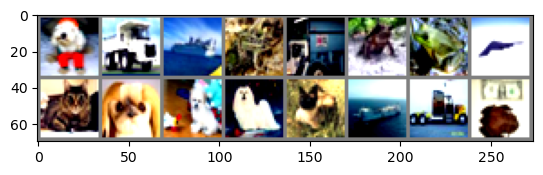

dog   truck ship  frog  truck frog  frog  plane cat   dog   dog   dog   cat   ship  truck frog 


In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



# functions for showing an image :
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


# Define The Neural Network

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.stack = nn.Sequential(
            # Convolutional Neural Network
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
            nn.Conv2d(6, 16,  5),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),

            # Flat the data for Fully Connected Networks (2d -> 1d)
            nn.Flatten(),

            # Fully Connected Network
            nn.Linear(16 * 5 * 5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10),
        )
    
    def forward(self, x):
        logits = self.stack(x)
        return logits


# Define a device and optimizer and loss function (criterion)

In [5]:
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cpu device


In [6]:
model = NeuralNetwork().to(device)

In [8]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
# Or You Can Use:
# optim = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

# Define function for training

In [ ]:
def train_set(model, optim, device, criterion, train_dataloader):
    running_loss, correct = 0, 0
    model.train()
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        optim.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optim.step()
        running_loss += loss.item()
        correct += (y_pred.argmax(1) == y).type(torch.float64).sum().item()
    
    return running_loss / len(train_dataloader), (correct / len(train_dataloader.dataset)) * 100